In [1]:
import sys,os
sys.path.append('..')
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.swarms.manager import SwarmManager
from backtester.exoinfo import EXOInfo

import pandas as pd
import numpy as np
import scipy

import glob
from pandas.tseries.offsets import *

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

figsize(20,10)

Populating the interactive namespace from numpy and matplotlib


## Rng strategies

In [3]:
#
# random time series
#
df = pd.DataFrame()
for i in range(100):
    
    date = pd.date_range(start='2015-01', end='2016-10', freq='D')
    price = np.random.randint(-100, 101, size=len(date))
    
    ser = pd.Series(price, index=date, name='rng_system'+str(i))
    df['rng_system'+str(i)] = ser.cumsum()

## Select input DF. Real swarms or RNG pseudo strategies

In [4]:
# Real swarms
#df = campaign_portfolio

# Rng strategies
#df = df

# Real swarms from csv
#df = pd.read_csv('./swarms_df/ma_cross_swarm_new.csv', parse_dates=[0],
#                dayfirst=True, index_col=0).asfreq(BDay())

# set file name here
swarm_file = 'GCE_CallSpread_SwingPoint_Long_bearish_breakout_Aggresive_Long (Small SPL)'

# Real swarm from .swm
df = SwarmManager.load('./temp_swarms/'+swarm_file+'.swm')
df = df.swarm

FileNotFoundError: [Errno 2] No such file or directory: './temp_swarms/GCE_CallSpread_SwingPoint_Long_bearish_breakout_Aggresive_Long (Small SPL).swm'

In [5]:
df = pd.DataFrame()

for file in glob.glob("./portfolios/*.csv"):
    
    portfolio_df = pd.read_csv(file, dayfirst=True, index_col=[0], parse_dates=[0], names=['date', file.split('\\')[1].split('.')[0]])
    portfolio_df = portfolio_df.groupby(portfolio_df.index).last().asfreq(BDay())
    
    #portfolio_df.columns[0] = file.split('\\')[1].split('.')[0]
    
    if len(df) == 0:
        df = portfolio_df
    else:
        df = pd.concat([df, portfolio_df],axis=1)
        
df = df.ffill().fillna(0.0)

In [6]:
all_equities_sum = df.sum(axis=1)

In [7]:
swarm = SwarmManager.load('./temp_swarms/'+swarm_file+'.swm')

FileNotFoundError: [Errno 2] No such file or directory: './temp_swarms/GCE_CallSpread_SwingPoint_Long_bearish_breakout_Aggresive_Long (Small SPL).swm'

## Systems overall performance estimation

In [8]:
temp_l = []

for strat in df.columns:

        input_strategy_data = df[strat] # This data is used in metrics calc

        price_change = input_strategy_data.diff()
        max_dd = (input_strategy_data - input_strategy_data.expanding().max()).min()
        netprofit = df[strat].ix[-1] - df[strat].ix[0]

        # Since swarm PnL statistics is not trade-by-trade
        # For PF calc I used cumulative values of positive and negatives price changes
        # Same for winrate
        profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())

        winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               

        try:
            modsharpe = np.mean(price_change) / np.std(price_change)

        except ZeroDivisionError:
            modsharpe = np.nan

        d = {'strategy': strat,
            'stats_pricechange_modsharpe': modsharpe, 
            'stats_netprofit': netprofit,
            'stats_max_dd': max_dd, 'stats_recovery_factor': netprofit / np.abs(max_dd),
            'stats_profit_factor': profit_factor, 'stats_winrate': winrate }

        temp_l.append(d)

In [9]:
strategies_performance_df = pd.DataFrame(temp_l).dropna()
strategies_performance_df['rank_score'] = np.zeros_like(len(strategies_performance_df))
strategies_performance_df

,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy,rank_score
0,-8212.0,40586.0,0.052744,1.252731,4.942280,24.027778,CLE_BullishCollar_IchimokuCloud_Long,0
1,-7592.0,48214.0,0.076517,1.354405,6.350632,29.444444,CLE_BullishCollar_IchimokuCloud_Short,0
2,-10550.0,20284.0,0.040063,1.387706,1.922654,10.416667,CLE_BullishCollar_MACross_Long,0
3,-9844.0,37404.0,0.058652,1.298011,3.799675,23.472222,CLE_BullishCollar_MACross_Short,0
4,-6784.0,40352.0,0.068906,1.478967,5.948113,16.111111,CLE_BullishCollar_PointAndFigurePatterns_Long,0
5,-5910.0,30378.0,0.073598,1.500940,5.140102,15.347222,CLE_BullishCollar_PointAndFigurePatterns_Short,0
6,-7144.0,25674.0,0.039743,1.196585,3.593785,22.083333,CLE_BullishCollar_RenkoPatterns_no_exit_on_pat...,0
7,-9360.0,27976.0,0.053409,1.286581,2.988889,18.680556,CLE_BullishCollar_RenkoPatterns_no_exit_on_pat...,0
8,-17396.0,18802.0,0.023123,1.100890,1.080823,24.722222,CLE_BullishCollar_SwingPoint_Long,0
9,-8656.0,45070.0,0.060310,1.320979,5.206793,23.263889,CLE_BullishCollar_SwingPoint_LongFailures,0


## Strategies overall performance ranking

In [10]:
ranks_d = {}

for col in strategies_performance_df.columns:
    
    stats_col_flag = False
    
    if 'stats' in col:

        # Define 0-10-20-30-40-50-60-70-80-90-100 quantiles values of certain strategy statistics
        metric_quantile0 = strategies_performance_df[col].quantile(0.0)
        metric_quantile10 = strategies_performance_df[col].quantile(0.1)
        metric_quantile20 = strategies_performance_df[col].quantile(0.2)
        metric_quantile30 = strategies_performance_df[col].quantile(0.3)
        metric_quantile40 = strategies_performance_df[col].quantile(0.4)
        metric_quantile50 = strategies_performance_df[col].quantile(0.5)
        metric_quantile60 = strategies_performance_df[col].quantile(0.6)
        metric_quantile70 = strategies_performance_df[col].quantile(0.7)
        metric_quantile80 = strategies_performance_df[col].quantile(0.8)
        metric_quantile90 = strategies_performance_df[col].quantile(0.9)
        metric_quantile100 = strategies_performance_df[col].quantile(1)
        
        stats_col_flag = True
    
    if stats_col_flag == True:
        
        for strat in strategies_performance_df.strategy:
        
            # Define strategy statistics rank of certain strategy

            strategy_stats_metric = strategies_performance_df[strategies_performance_df.strategy == strat][col].values[0]

            if strategy_stats_metric >= metric_quantile0 and strategy_stats_metric <= metric_quantile10:
                rank_score = 0

            elif strategy_stats_metric >= metric_quantile10 and strategy_stats_metric <= metric_quantile20:
                rank_score = 1

            elif strategy_stats_metric >= metric_quantile20 and strategy_stats_metric <= metric_quantile30:
                rank_score = 2

            elif strategy_stats_metric >= metric_quantile30 and strategy_stats_metric <= metric_quantile40:
                rank_score = 3

            elif strategy_stats_metric >= metric_quantile40 and strategy_stats_metric <= metric_quantile50:
                rank_score = 4

            elif strategy_stats_metric >= metric_quantile50 and strategy_stats_metric <= metric_quantile60:
                rank_score = 5

            elif strategy_stats_metric >= metric_quantile60 and strategy_stats_metric <= metric_quantile70:
                rank_score = 6

            elif strategy_stats_metric >= metric_quantile70 and strategy_stats_metric <= metric_quantile80:
                rank_score = 7

            elif strategy_stats_metric >= metric_quantile80 and strategy_stats_metric <= metric_quantile90:
                rank_score = 8

            elif strategy_stats_metric >= metric_quantile90 and strategy_stats_metric <= metric_quantile100:
                rank_score = 9

            elif strategy_stats_metric == metric_quantile100:
                rank_score = 10

                
            if strat not in ranks_d.keys():               
                ranks_d[strat] = rank_score
                
            elif strat in ranks_d.keys():                
                ranks_d[strat] = ranks_d[strat] + rank_score
                          
            # For debugging purposes

            #print('strategy---',strat,'\n')
            #print(col)
            #print('10 quantile---',metric_quantile10)
            #print(strategy_stats_metric)
            #print('60 quantile---',metric_quantile60)
            #print(strategy_stats_metric > metric_quantile40 and strategy_stats_metric < metric_quantile50)
            #print('rank_score------', rank_score, '\n')

        #print("NEXT----------------------- \n")

# Set rank scores for strategies from dict

for k in ranks_d:
    
    strat_index = strategies_performance_df[strategies_performance_df.strategy == k].index
    strategies_performance_df = strategies_performance_df.set_value(strat_index, 'rank_score', ranks_d[k])

In [11]:
strategies_performance_df.sort_values('rank_score', ascending=False)

,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy,rank_score
1,-7592.0,48214.0,0.076517,1.354405,6.350632,29.444444,CLE_BullishCollar_IchimokuCloud_Short,50
4,-6784.0,40352.0,0.068906,1.478967,5.948113,16.111111,CLE_BullishCollar_PointAndFigurePatterns_Long,43
9,-8656.0,45070.0,0.060310,1.320979,5.206793,23.263889,CLE_BullishCollar_SwingPoint_LongFailures,39
5,-5910.0,30378.0,0.073598,1.500940,5.140102,15.347222,CLE_BullishCollar_PointAndFigurePatterns_Short,38
13,-16440.0,71624.0,0.064657,1.258000,4.356691,39.652778,CLE_CallSpread_IchimokuCloud_Short,34
3,-9844.0,37404.0,0.058652,1.298011,3.799675,23.472222,CLE_BullishCollar_MACross_Short,32
0,-8212.0,40586.0,0.052744,1.252731,4.942280,24.027778,CLE_BullishCollar_IchimokuCloud_Long,30
10,-12628.0,44438.0,0.058501,1.279084,3.519005,26.944444,CLE_BullishCollar_SwingPoint_Short,28
7,-9360.0,27976.0,0.053409,1.286581,2.988889,18.680556,CLE_BullishCollar_RenkoPatterns_no_exit_on_pat...,23
6,-7144.0,25674.0,0.039743,1.196585,3.593785,22.083333,CLE_BullishCollar_RenkoPatterns_no_exit_on_pat...,21


## Drop all strategies which have rank score less than n quantile value 

In [12]:
df = df[strategies_performance_df[strategies_performance_df.rank_score >= strategies_performance_df.rank_score.quantile(0.0)].strategy]

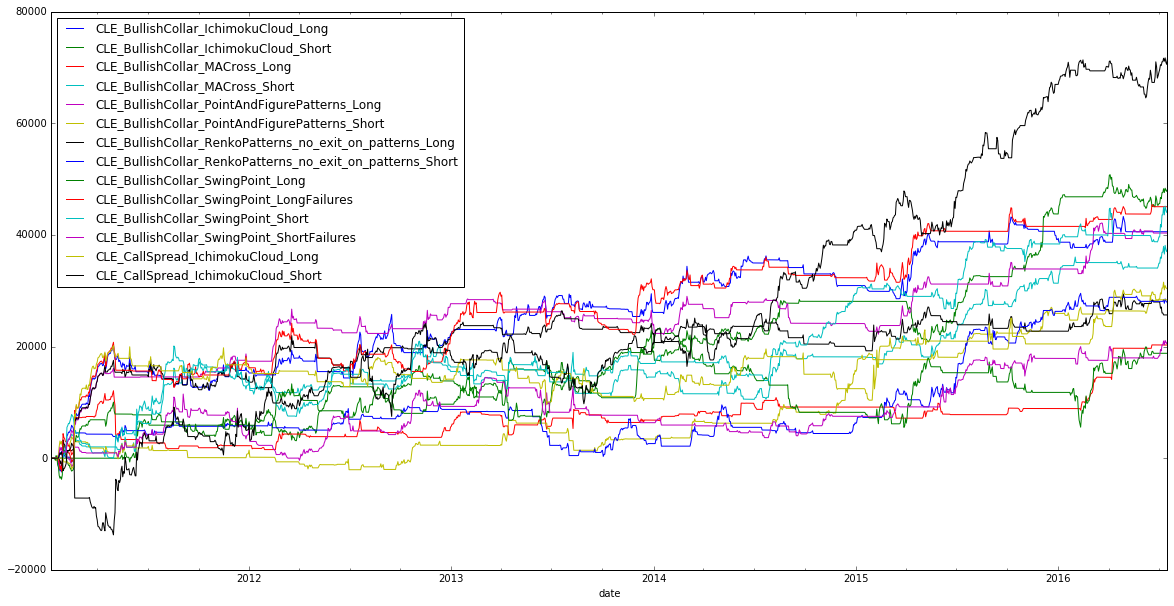

In [13]:
df.dropna().plot()

## Filter those strategies by correlation

In [14]:
# Rearrange columns from best to worst strategies
df = df.reindex_axis(strategies_performance_df.sort_values('rank_score', ascending=False).strategy, axis=1).dropna(axis=1).asfreq(BDay())

In [15]:
df.corr()

strategy,CLE_BullishCollar_IchimokuCloud_Short,CLE_BullishCollar_PointAndFigurePatterns_Long,CLE_BullishCollar_SwingPoint_LongFailures,CLE_BullishCollar_PointAndFigurePatterns_Short,CLE_CallSpread_IchimokuCloud_Short,CLE_BullishCollar_MACross_Short,CLE_BullishCollar_IchimokuCloud_Long,CLE_BullishCollar_SwingPoint_Short,CLE_BullishCollar_RenkoPatterns_no_exit_on_patterns_Short,CLE_BullishCollar_RenkoPatterns_no_exit_on_patterns_Long,CLE_BullishCollar_MACross_Long,CLE_CallSpread_IchimokuCloud_Long,CLE_BullishCollar_SwingPoint_Long,CLE_BullishCollar_SwingPoint_ShortFailures
strategy,,,,,,,,,,,,,,
CLE_BullishCollar_IchimokuCloud_Short,1.000000,0.839321,0.900254,0.907030,0.970838,0.901029,0.886306,0.933543,0.810769,0.698599,0.784506,0.633908,0.541435,0.792081
CLE_BullishCollar_PointAndFigurePatterns_Long,0.839321,1.000000,0.891842,0.726142,0.838239,0.825806,0.883440,0.795236,0.727744,0.921801,0.758250,0.731687,0.737060,0.757784
CLE_BullishCollar_SwingPoint_LongFailures,0.900254,0.891842,1.000000,0.861841,0.892992,0.787420,0.978775,0.859256,0.695789,0.839030,0.784878,0.693979,0.714992,0.711557
CLE_BullishCollar_PointAndFigurePatterns_Short,0.907030,0.726142,0.861841,1.000000,0.943584,0.853282,0.818416,0.933493,0.871312,0.557569,0.729263,0.686212,0.421928,0.803091
CLE_CallSpread_IchimokuCloud_Short,0.970838,0.838239,0.892992,0.943584,1.000000,0.934721,0.862078,0.969225,0.866865,0.666787,0.717842,0.664720,0.487288,0.833251
CLE_BullishCollar_MACross_Short,0.901029,0.825806,0.787420,0.853282,0.934721,1.000000,0.752851,0.950551,0.900804,0.623313,0.625891,0.705762,0.422754,0.888784
CLE_BullishCollar_IchimokuCloud_Long,0.886306,0.883440,0.978775,0.818416,0.862078,0.752851,1.000000,0.830373,0.644334,0.859416,0.764183,0.658742,0.720989,0.684467
CLE_BullishCollar_SwingPoint_Short,0.933543,0.795236,0.859256,0.933493,0.969225,0.950551,0.830373,1.000000,0.857964,0.635654,0.653057,0.674351,0.447993,0.873080
CLE_BullishCollar_RenkoPatterns_no_exit_on_patterns_Short,0.810769,0.727744,0.695789,0.871312,0.866865,0.900804,0.644334,0.857964,1.000000,0.471379,0.626559,0.760742,0.347208,0.859558


In [16]:
corr_df = df.corr()

while_loop_break_flag = False

while True:   
    if while_loop_break_flag == False:
        
        for i in range(len(corr_df)):

            try:       
                strat_corr = corr_df[corr_df.columns[i]]
            
            except IndexError:               
                strat_corr = corr_df[corr_df.columns[-1]]
            
            df = df.drop(strat_corr[(strat_corr.index != strat_corr.name) & (strat_corr >= 0.99)].index, axis=1)

            # Check if previous DF are the same as current DF
            # If they are different - continue the loop

            df_comparison_array = np.array_equal(corr_df,df.corr())
            
            #print(strat_corr[(strat_corr.index != strat_corr.name) & (strat_corr >= 0.5)].index)
            #print(i)
            #print(len(corr_df))
            #print(len(corr_df))
            
            if df_comparison_array  == False and i < len(corr_df):
                corr_df = df.corr()

            elif df_comparison_array  == True and i == len(corr_df)-1:
                while_loop_break_flag = True
                break
                    
    if while_loop_break_flag == True:
        break

In [17]:
df.corr()

strategy,CLE_BullishCollar_IchimokuCloud_Short,CLE_BullishCollar_PointAndFigurePatterns_Long,CLE_BullishCollar_SwingPoint_LongFailures,CLE_BullishCollar_PointAndFigurePatterns_Short,CLE_CallSpread_IchimokuCloud_Short,CLE_BullishCollar_MACross_Short,CLE_BullishCollar_IchimokuCloud_Long,CLE_BullishCollar_SwingPoint_Short,CLE_BullishCollar_RenkoPatterns_no_exit_on_patterns_Short,CLE_BullishCollar_RenkoPatterns_no_exit_on_patterns_Long,CLE_BullishCollar_MACross_Long,CLE_CallSpread_IchimokuCloud_Long,CLE_BullishCollar_SwingPoint_Long,CLE_BullishCollar_SwingPoint_ShortFailures
strategy,,,,,,,,,,,,,,
CLE_BullishCollar_IchimokuCloud_Short,1.000000,0.839321,0.900254,0.907030,0.970838,0.901029,0.886306,0.933543,0.810769,0.698599,0.784506,0.633908,0.541435,0.792081
CLE_BullishCollar_PointAndFigurePatterns_Long,0.839321,1.000000,0.891842,0.726142,0.838239,0.825806,0.883440,0.795236,0.727744,0.921801,0.758250,0.731687,0.737060,0.757784
CLE_BullishCollar_SwingPoint_LongFailures,0.900254,0.891842,1.000000,0.861841,0.892992,0.787420,0.978775,0.859256,0.695789,0.839030,0.784878,0.693979,0.714992,0.711557
CLE_BullishCollar_PointAndFigurePatterns_Short,0.907030,0.726142,0.861841,1.000000,0.943584,0.853282,0.818416,0.933493,0.871312,0.557569,0.729263,0.686212,0.421928,0.803091
CLE_CallSpread_IchimokuCloud_Short,0.970838,0.838239,0.892992,0.943584,1.000000,0.934721,0.862078,0.969225,0.866865,0.666787,0.717842,0.664720,0.487288,0.833251
CLE_BullishCollar_MACross_Short,0.901029,0.825806,0.787420,0.853282,0.934721,1.000000,0.752851,0.950551,0.900804,0.623313,0.625891,0.705762,0.422754,0.888784
CLE_BullishCollar_IchimokuCloud_Long,0.886306,0.883440,0.978775,0.818416,0.862078,0.752851,1.000000,0.830373,0.644334,0.859416,0.764183,0.658742,0.720989,0.684467
CLE_BullishCollar_SwingPoint_Short,0.933543,0.795236,0.859256,0.933493,0.969225,0.950551,0.830373,1.000000,0.857964,0.635654,0.653057,0.674351,0.447993,0.873080
CLE_BullishCollar_RenkoPatterns_no_exit_on_patterns_Short,0.810769,0.727744,0.695789,0.871312,0.866865,0.900804,0.644334,0.857964,1.000000,0.471379,0.626559,0.760742,0.347208,0.859558


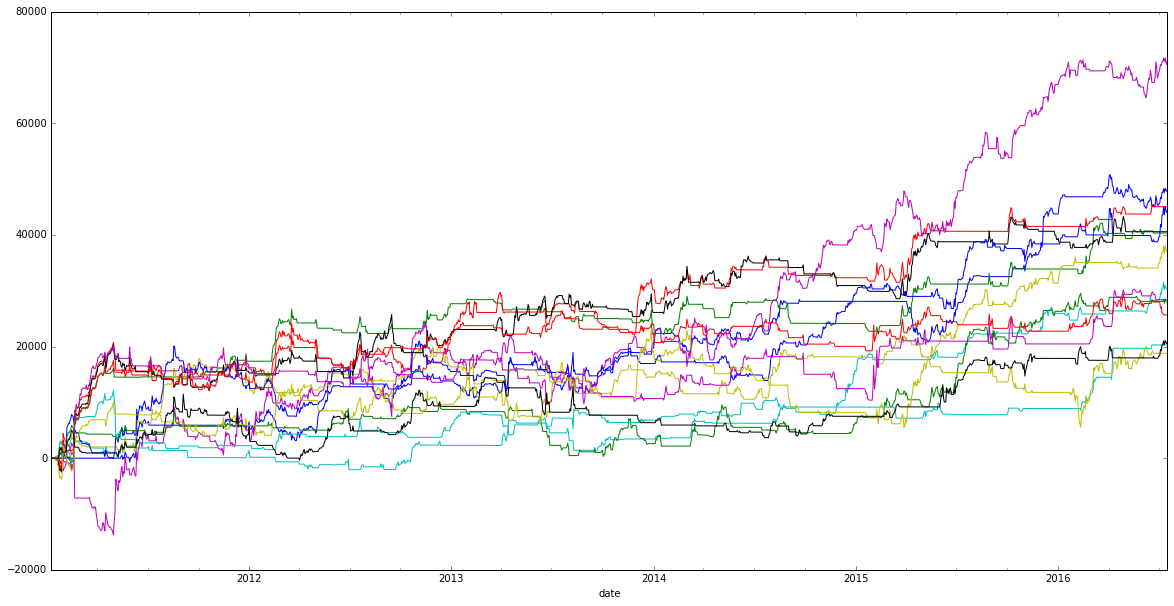

In [18]:
df.dropna().plot(legend=False)

# Metrics calculation

In [12]:
#
# Rebalance triggers
#
# Rebalance trigger must be array of Datetime indexes when event occurred, like date of monday or new month
# 
newmonth = df[df.index.month != df.index.shift(1).month].index

monday = df[df.index.weekday == 0].index

norebalance = [df.index[-1]]

newyear = df[df.index.year != df.index.shift(1).year].index
#
#
#

# note: I think more performance metrics for strategies is better
# https://www.amibroker.com/guide/h_report.html for reference

rebalance_index = 1
rebalance_date_start = None

rebalance_trigger = monday # set rebalance trigger here

temp_l = []

for reb_idx in rebalance_trigger:
    
    for strat in df.columns:

        if rebalance_index == 1:
            rebalance_date_start = df.index[0]
           
        for i in range(len(df[strat])):

            if df[strat].index[i] == reb_idx:

                input_strategy_data = df[strat].ix[rebalance_date_start:reb_idx] # This data is used in metrics calc
                
                price_change = input_strategy_data.diff()
                max_dd = (input_strategy_data - input_strategy_data.expanding().max()).min()
                netprofit = df[strat].ix[reb_idx] - df[strat].ix[rebalance_date_start]
                
                # Since swarm PnL statistics is not trade-by-trade
                # For PF calc I used cumulative values of positive and negatives price changes
                # Same for winrate
                profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())
                
                winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               
                # If all trades are negative, PF is 0. But later all 0s is replaced with NaN. 
                # To avoid replacing true 0.0 PF set it to 0.000001
                # This made for handling missing data 
                
                # Also winrate can be 0.0, but if PF is NaN - no trades were made
                # This made for handling missing data 
                
                if winrate == 0.0 and np.isnan(profit_factor) == False:
                    winrate = 0.000001
                
                elif winrate == 0.0 and np.isnan(profit_factor) == True:
                    winrate = np.nan
                                
                if profit_factor == 0.0:
                    profit_factor = 0.000001                
                          
                try:
                    modsharpe = np.mean(price_change) / np.std(price_change)
                    
                except ZeroDivisionError:
                    modsharpe = np.nan
            
                
                d = {'strategy': strat,'rebalance_date_start': rebalance_date_start,
                    'rebalance_date_end': reb_idx, 'rebalance_index': rebalance_index,
                    'stats_pricechange_modsharpe': modsharpe, 
                    'stats_netprofit': netprofit,
                    'stats_max_dd': max_dd, 'stats_recovery_factor': netprofit / np.abs(max_dd),
                    'stats_profit_factor': profit_factor, 'stats_winrate': winrate }
                
                '''
                d = {'strategy': strat,'rebalance_date_start': rebalance_date_start,
                    'rebalance_date_end': reb_idx, 'rebalance_index': rebalance_index,
                    'stats_pricechange_modsharpe': modsharpe, 
                    'stats_recovery_factor': netprofit / np.abs(max_dd)}
                '''
                
                temp_l.append(d)
    
    rebalance_index += 1
    rebalance_date_start = reb_idx # set new start rebalance date to current rebalance trigger date

### Data cleaning

In [13]:
# Replacing 0 values with NaNs
# If strategy stats is 0 means that no trades were made
stats_df = pd.DataFrame(temp_l).replace(0, np.nan)

# Filling NaNs with last avaible values
for s in stats_df.strategy.unique():
    stats_df[stats_df.strategy == s] = stats_df[stats_df.strategy == s].fillna(method='pad')

stats_df = stats_df.dropna(how='any')

In [14]:
stats_df

,rebalance_date_end,rebalance_date_start,rebalance_index,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy
14,2011-01-17,2011-01-10,2,-180.0,-180.0,-0.500000,0.000001,-1.000000,0.000001,CLE_BullishCollar_IchimokuCloud_Long
18,2011-01-17,2011-01-10,2,-180.0,-180.0,-0.500000,0.000001,-1.000000,0.000001,CLE_BullishCollar_PointAndFigurePatterns_Long
19,2011-01-17,2011-01-10,2,-18.0,-18.0,-0.500000,0.000001,-1.000000,0.000001,CLE_BullishCollar_PointAndFigurePatterns_Short
22,2011-01-17,2011-01-10,2,-360.0,-360.0,-0.500000,0.000001,-1.000000,0.000001,CLE_BullishCollar_SwingPoint_Long
28,2011-01-24,2011-01-17,3,-2040.0,-1620.0,-0.664102,0.205882,-0.794118,20.000000,CLE_BullishCollar_IchimokuCloud_Long
32,2011-01-24,2011-01-17,3,-1340.0,-920.0,-0.473285,0.313433,-0.686567,20.000000,CLE_BullishCollar_PointAndFigurePatterns_Long
33,2011-01-24,2011-01-17,3,-420.0,2120.0,0.659589,6.047619,5.047619,80.000000,CLE_BullishCollar_PointAndFigurePatterns_Short
34,2011-01-24,2011-01-17,3,-36.0,-36.0,-0.500000,0.000001,-1.000000,0.000001,CLE_BullishCollar_RenkoPatterns_no_exit_on_pat...
36,2011-01-24,2011-01-17,3,-3580.0,-2740.0,-0.645065,0.234637,-0.765363,20.000000,CLE_BullishCollar_SwingPoint_Long
37,2011-01-24,2011-01-17,3,-1000.0,-1000.0,-0.500000,0.000001,-1.000000,0.000001,CLE_BullishCollar_SwingPoint_LongFailures


## Statistics rank calculation

In [15]:
ranks_d = {}
ranks_rebidx_d = {}

for i in stats_df.rebalance_index.unique():

    for col in stats_df[stats_df.rebalance_index == i].columns:
        
        stats_col_flag = False
    
        if 'stats' in col:

            # Define 0-10-20-30-40-50-60-70-80-90-100 quantiles values of certain strategy statistics
            metric_quantile0 = stats_df[col].quantile(0.0)
            metric_quantile10 = stats_df[col].quantile(0.1)
            metric_quantile20 = stats_df[col].quantile(0.2)
            metric_quantile30 = stats_df[col].quantile(0.3)
            metric_quantile40 = stats_df[col].quantile(0.4)
            metric_quantile50 = stats_df[col].quantile(0.5)
            metric_quantile60 = stats_df[col].quantile(0.6)
            metric_quantile70 = stats_df[col].quantile(0.7)
            metric_quantile80 = stats_df[col].quantile(0.8)
            metric_quantile90 = stats_df[col].quantile(0.9)
            metric_quantile100 = stats_df[col].quantile(1)

            stats_col_flag = True

        if stats_col_flag == True:
    
            for strat in stats_df[stats_df.rebalance_index == i].strategy:

                # Define strategy statistics rank of certain strategy

                strategy_stats_metric = stats_df[(stats_df.rebalance_index == i) 
                                                 & (stats_df.strategy == strat)][col].values[0]

                if strategy_stats_metric >= metric_quantile0 and strategy_stats_metric <= metric_quantile10:
                    rank_score = 0

                elif strategy_stats_metric >= metric_quantile10 and strategy_stats_metric <= metric_quantile20:
                    rank_score = 1

                elif strategy_stats_metric >= metric_quantile20 and strategy_stats_metric <= metric_quantile30:
                    rank_score = 2

                elif strategy_stats_metric >= metric_quantile30 and strategy_stats_metric <= metric_quantile40:
                    rank_score = 3

                elif strategy_stats_metric >= metric_quantile40 and strategy_stats_metric <= metric_quantile50:
                    rank_score = 4

                elif strategy_stats_metric >= metric_quantile50 and strategy_stats_metric <= metric_quantile60:
                    rank_score = 5

                elif strategy_stats_metric >= metric_quantile60 and strategy_stats_metric <= metric_quantile70:
                    rank_score = 6

                elif strategy_stats_metric >= metric_quantile70 and strategy_stats_metric <= metric_quantile80:
                    rank_score = 7

                elif strategy_stats_metric >= metric_quantile80 and strategy_stats_metric <= metric_quantile90:
                    rank_score = 8

                elif strategy_stats_metric >= metric_quantile90 and strategy_stats_metric <= metric_quantile100:
                    rank_score = 9

                elif strategy_stats_metric == metric_quantile100:
                    rank_score = 10

                    
                if strat not in ranks_d.keys():               
                    ranks_d[strat] = rank_score
                    
                elif strat in ranks_d.keys():                
                    ranks_d[strat] = ranks_d[strat] + rank_score
            #ranks_d['rebalance_idx_'+str(i)] = i

                    
                # For debugging purposes

                #print('strategy---',strat,'\n')
                #print(col)
                #print('10 quantile---',metric_quantile10)
                #print(strategy_stats_metric)
                #print('60 quantile---',metric_quantile60)
                #print(strategy_stats_metric > metric_quantile40 and strategy_stats_metric < metric_quantile50)
                #print('rank_score------', rank_score, '\n')

    
    print('rebalance index ---', i)
    #break
    for k in ranks_d:

        strat_index = stats_df[(stats_df.strategy == k) & ((stats_df.rebalance_index == i))].index
        #print(strat_index)
        stats_df = stats_df.set_value(strat_index, 'rank_score', ranks_d[k])
        
    ranks_d = {}

rebalance index --- 2
rebalance index --- 3
rebalance index --- 4
rebalance index --- 5
rebalance index --- 6
rebalance index --- 7
rebalance index --- 8
rebalance index --- 9
rebalance index --- 10
rebalance index --- 11
rebalance index --- 12
rebalance index --- 13
rebalance index --- 14
rebalance index --- 15
rebalance index --- 16
rebalance index --- 17
rebalance index --- 18
rebalance index --- 19
rebalance index --- 20
rebalance index --- 21
rebalance index --- 22
rebalance index --- 23
rebalance index --- 24
rebalance index --- 25
rebalance index --- 26
rebalance index --- 27
rebalance index --- 28
rebalance index --- 29
rebalance index --- 30
rebalance index --- 31
rebalance index --- 32
rebalance index --- 33
rebalance index --- 34
rebalance index --- 35
rebalance index --- 36
rebalance index --- 37
rebalance index --- 38
rebalance index --- 39
rebalance index --- 40
rebalance index --- 41
rebalance index --- 42
rebalance index --- 43
rebalance index --- 44
rebalance index ---

### Strategies picker

In [71]:
# Trade-by-trade pnl
pnl_df = df.diff() - 18

summary_best_eqty = pd.Series()
summary_worst_eqty = pd.Series()
benchmark_eqty = pd.Series()

rebalance_history_l = []

# We can set start rebalance index value to 
for i in range(stats_df.rebalance_index.unique().min(),stats_df.rebalance_index.unique().max()):
    
    if i < 2:
        # We must estimate strategies preformance at least on one rebalance window
        continue
        
    else:

        # Pick strats from previous rebalance, but trade them until next rebalance
                        
        start_date = stats_df[stats_df.rebalance_index == i].rebalance_date_start.values[0]  
        end_date = stats_df[stats_df.rebalance_index == i].rebalance_date_end.values[0]
        
        # Number of picked strats defined by .strategy.values[:number]
        # Remove -1 from 'i - 1' to get holy grail :D (future reference)
        
        picked_best_strats = stats_df[stats_df.rebalance_index == i - 1].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[:3]
        
        picked_worst_strats = stats_df[stats_df.rebalance_index == i - 1].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[-3:]
        
        all_strats = stats_df[stats_df.rebalance_index == i - 1].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[:]
        
        if len(summary_best_eqty) == 0 and len(summary_worst_eqty) == 0 and len(benchmark_eqty) == 0:
            summary_best_eqty = pnl_df[picked_best_strats].ix[start_date : end_date].sum(axis=1)           
            summary_worst_eqty = pnl_df[picked_worst_strats].ix[start_date : end_date].sum(axis=1)
            
            benchmark_eqty = pnl_df[all_strats].ix[start_date : end_date].sum(axis=1)      
            
        else:
            summary_best_eqty = summary_best_eqty.append(pnl_df[picked_best_strats].ix[start_date : end_date].sum(axis=1))
            summary_worst_eqty = summary_worst_eqty.append(pnl_df[picked_worst_strats].ix[start_date : end_date].sum(axis=1))
            
            benchmark_eqty = benchmark_eqty.append(pnl_df[all_strats].ix[start_date : end_date].sum(axis=1))
        
        d = {'rebalance_index': i, 'best_strategies_list': picked_best_strats}
        
        for s in range(len(picked_best_strats)):
            d['strategy_'+str(s)] = picked_best_strats[s]
        
        rebalance_history_l.append(d)
        
        
best_portfolio = summary_best_eqty.cumsum()
worst_portfolio = summary_worst_eqty.cumsum() * -1 # Reversed

summary_portfolio = best_portfolio + worst_portfolio

benchmark_portfolio = benchmark_eqty.cumsum()

## Rebalance history


In [91]:
rebalance_history_df = pd.DataFrame(rebalance_history_l)
rebalance_history_df.index = rebalance_history_df.rebalance_index


same_strats_counter = 0
different_strats_counter = 0

same_strats_counter_l = []
different_strats_counter_l = []

for i in rebalance_history_df.index:
    
    if i > rebalance_history_df.index[0]+1:
        
        for c in rebalance_history_df.columns:
            
            if 'strategy' in c:
                
                if rebalance_history_df[c][i] in rebalance_history_df.best_strategies_list[i-1]:
                    same_strats_counter += 1
                
                if rebalance_history_df[c][i] not in rebalance_history_df.best_strategies_list[i-1]:
                    different_strats_counter += 1
    
    same_strats_counter_l.append(same_strats_counter)
    different_strats_counter_l.append(different_strats_counter)
    
    same_strats_counter = 0
    different_strats_counter = 0

rebalance_history_df['same_strategies'] = same_strats_counter_l
rebalance_history_df['different_strategies'] = different_strats_counter_l

In [104]:
rebalance_history_df

,best_strategies_list,rebalance_index,strategy_0,strategy_1,strategy_2,same_strategies,different_strategies
rebalance_index,,,,,,,
2,[],2,NaN,NaN,NaN,0,0
3,[CLE_BullishCollar_PointAndFigurePatterns_Shor...,3,CLE_BullishCollar_PointAndFigurePatterns_Short,CLE_BullishCollar_IchimokuCloud_Long,CLE_BullishCollar_PointAndFigurePatterns_Long,0,0
4,[CLE_BullishCollar_PointAndFigurePatterns_Shor...,4,CLE_BullishCollar_PointAndFigurePatterns_Short,CLE_BullishCollar_PointAndFigurePatterns_Long,CLE_BullishCollar_RenkoPatterns_no_exit_on_pat...,2,1
5,"[CLE_BullishCollar_SwingPoint_Long, CLE_Bullis...",5,CLE_BullishCollar_SwingPoint_Long,CLE_BullishCollar_PointAndFigurePatterns_Long,CLE_BullishCollar_IchimokuCloud_Long,1,2
6,"[CLE_BullishCollar_SwingPoint_Short, CLE_Bulli...",6,CLE_BullishCollar_SwingPoint_Short,CLE_BullishCollar_RenkoPatterns_no_exit_on_pat...,CLE_CallSpread_IchimokuCloud_Short,0,3
7,"[CLE_BullishCollar_SwingPoint_Short, CLE_Bulli...",7,CLE_BullishCollar_SwingPoint_Short,CLE_BullishCollar_SwingPoint_ShortFailures,CLE_BullishCollar_MACross_Short,1,2
8,[CLE_BullishCollar_RenkoPatterns_no_exit_on_pa...,8,CLE_BullishCollar_RenkoPatterns_no_exit_on_pat...,CLE_BullishCollar_SwingPoint_Long,CLE_BullishCollar_IchimokuCloud_Long,0,3
9,"[CLE_BullishCollar_MACross_Long, CLE_CallSprea...",9,CLE_BullishCollar_MACross_Long,CLE_CallSpread_IchimokuCloud_Long,CLE_BullishCollar_IchimokuCloud_Long,1,2
10,"[CLE_BullishCollar_IchimokuCloud_Long, CLE_Bul...",10,CLE_BullishCollar_IchimokuCloud_Long,CLE_BullishCollar_PointAndFigurePatterns_Long,CLE_BullishCollar_RenkoPatterns_no_exit_on_pat...,1,2


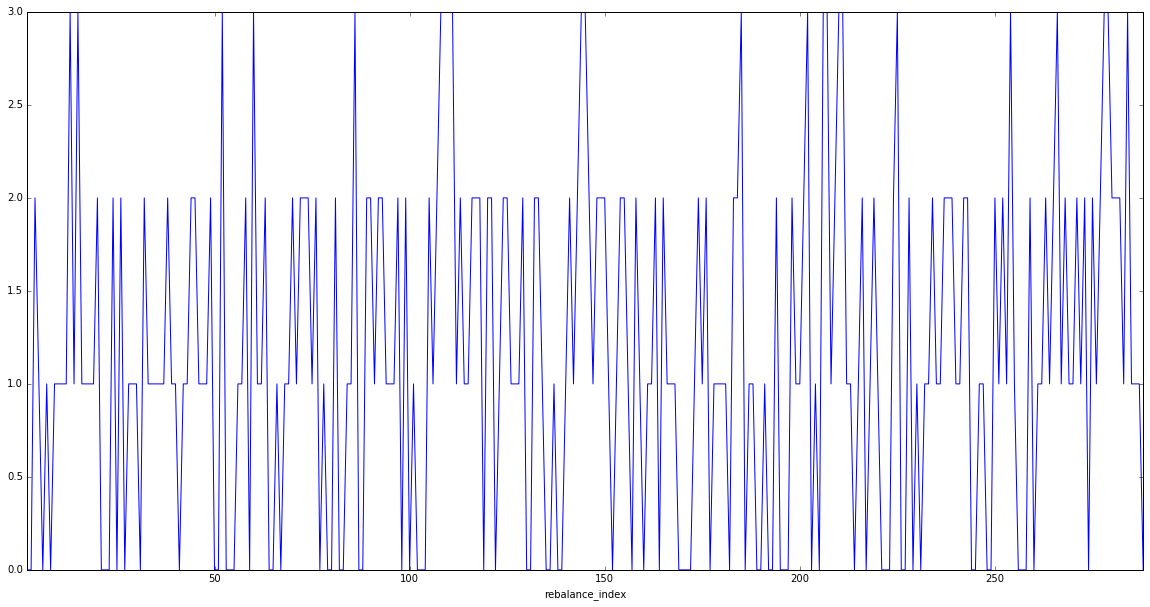

In [93]:
rebalance_history_df.same_strategies.plot()

In [100]:
rebalance_history_df.same_strategies[rebalance_history_df.same_strategies == 0].count() / rebalance_history_df.same_strategies.count()

0.27526132404181186

In [101]:
rebalance_history_df.same_strategies[rebalance_history_df.same_strategies == 1].count() / rebalance_history_df.same_strategies.count()

0.37282229965156793

In [102]:
rebalance_history_df.same_strategies[rebalance_history_df.same_strategies == 2].count() / rebalance_history_df.same_strategies.count()

0.27177700348432055

In [103]:
rebalance_history_df.same_strategies[rebalance_history_df.same_strategies == 3].count() / rebalance_history_df.same_strategies.count()

0.080139372822299645

## Comparing portfolios stats with benchmark(all strategies equity)

In [17]:
def portfolio_stats(portfolio_ser,label):
    input_data = portfolio_ser # This data is used in metrics calc
                
    price_change = input_data.diff()
    max_dd = (input_data - input_data.expanding().max()).min()
    netprofit = input_data.ix[input_data.index[-1]] - input_data.ix[input_data.index[0]]

    # Since swarm PnL statistics is not trade-by-trade
    # For PF calc I used cumulative values of positive and negatives price changes
    # Same for winrate
    profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())

    winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               

    modsharpe = np.mean(price_change) / np.std(price_change)

    recovery_factor = netprofit / np.abs(max_dd)

    print('Portfolio name ---', str(label))
    print('\n')
    print('PriceChange Mod. Sharpe', modsharpe)
    print('Netprofit',netprofit)
    print('Max DD', max_dd)
    print('Recovery Factor', recovery_factor)
    print('Profit factor', profit_factor)
    print('Winrate', winrate)

    input_data.plot(kind='area', stacked=False)

Portfolio name --- Best


PriceChange Mod. Sharpe 0.15715429028423145
Netprofit 488986.0
Max DD -24532.0
Recovery Factor 19.9325778575
Profit factor 1.68859435421
Winrate 51.481696688


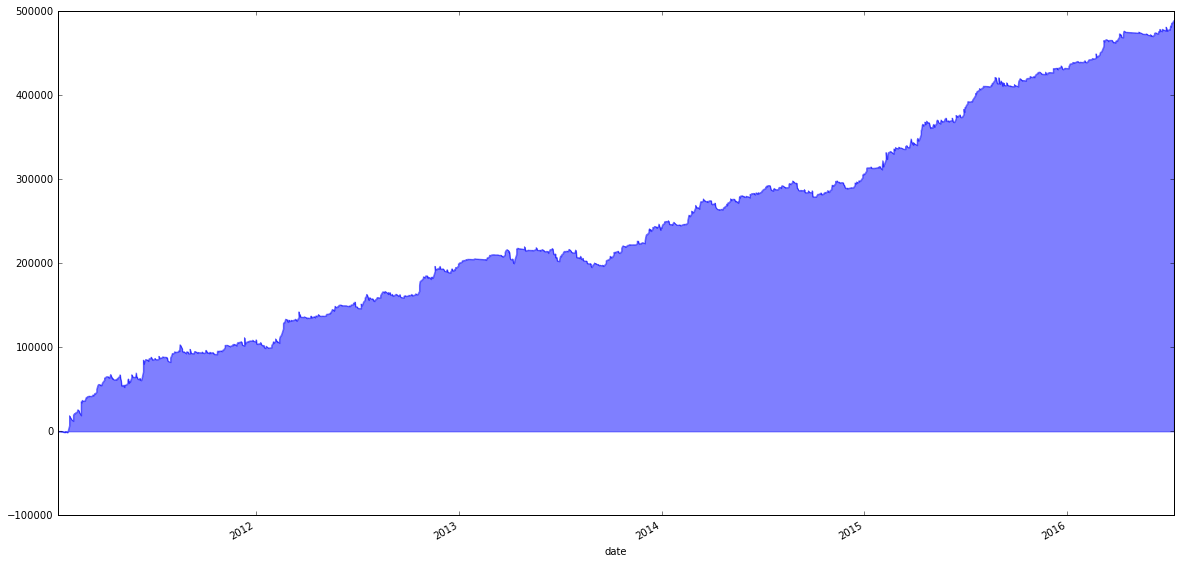

In [18]:
portfolio_stats(best_portfolio, 'Best')

Portfolio name --- Worst(reversed)


PriceChange Mod. Sharpe 0.07929345018995772
Netprofit 124568.0
Max DD -33850.0
Recovery Factor 3.68
Profit factor 1.52343894445
Winrate 84.1952353283


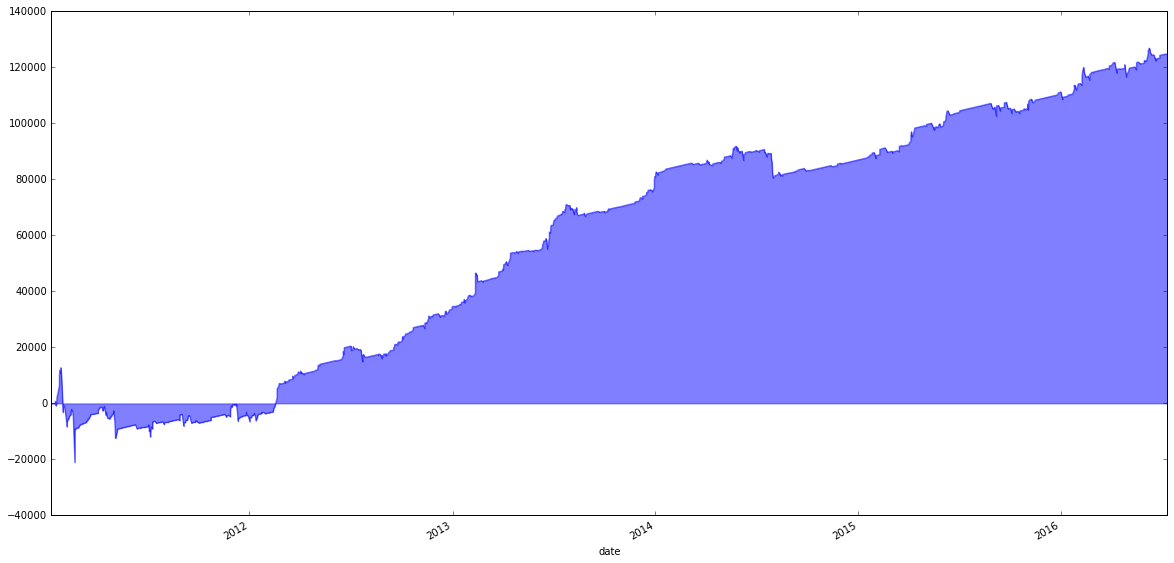

In [48]:
portfolio_stats(worst_portfolio, 'Worst(reversed)')

Portfolio name --- Summary(Best + Worst)


PriceChange Mod. Sharpe 0.15705021673175526
Netprofit 620086.0
Max DD -35134.0
Recovery Factor 17.6491717425
Profit factor 1.71390611364
Winrate 55.8977338757


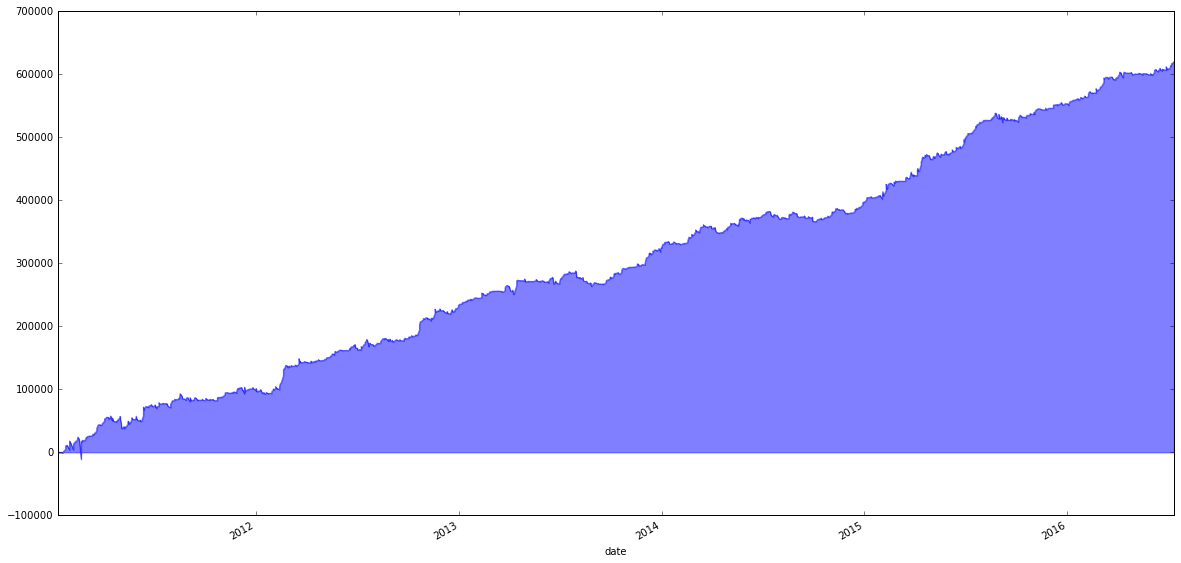

In [49]:
portfolio_stats(summary_portfolio, 'Summary(Best + Worst)')

Portfolio name --- Benchmark(Trade all strategies)


PriceChange Mod. Sharpe 0.10562627529093178
Netprofit 542714.0
Max DD -61416.0
Recovery Factor 8.83668750814
Profit factor 1.42742674786
Winrate 50.0290528762


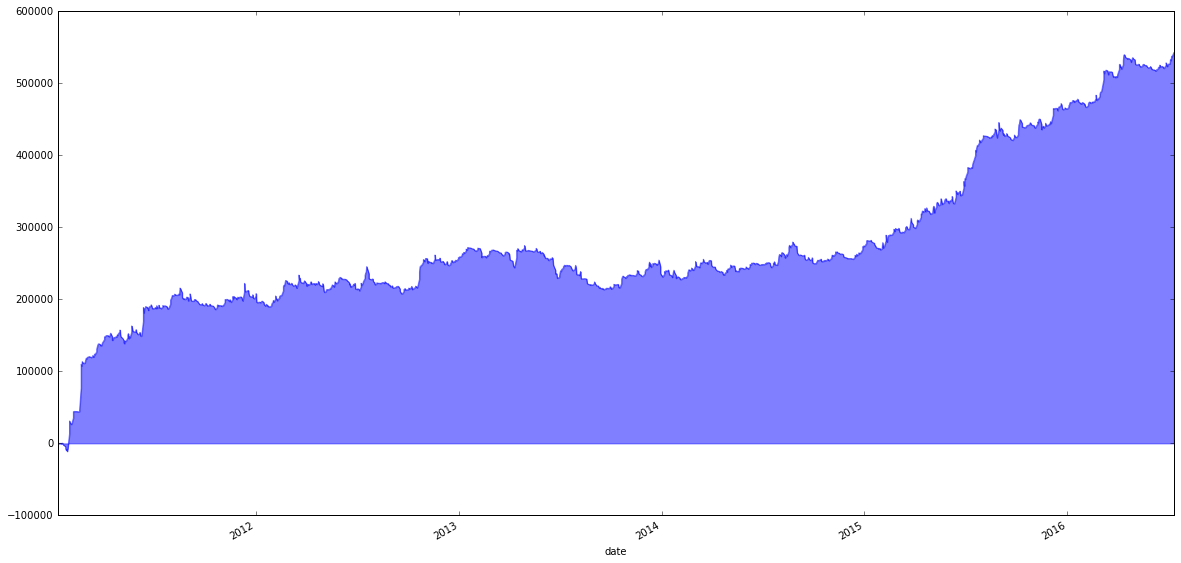

In [50]:
portfolio_stats(benchmark_portfolio, 'Benchmark(Trade all strategies)')

In [51]:
portfolio_stats(swarm.swarm_picked.sum(axis=1), 'Picked swarm with current approach')

NameError: name 'swarm' is not defined

Portfolio name --- All equities


PriceChange Mod. Sharpe 0.12604714366915892
Netprofit 500128.0
Max DD -33566.0
Recovery Factor 14.8998391229
Profit factor 1.51607683862
Winrate 57.8472222222


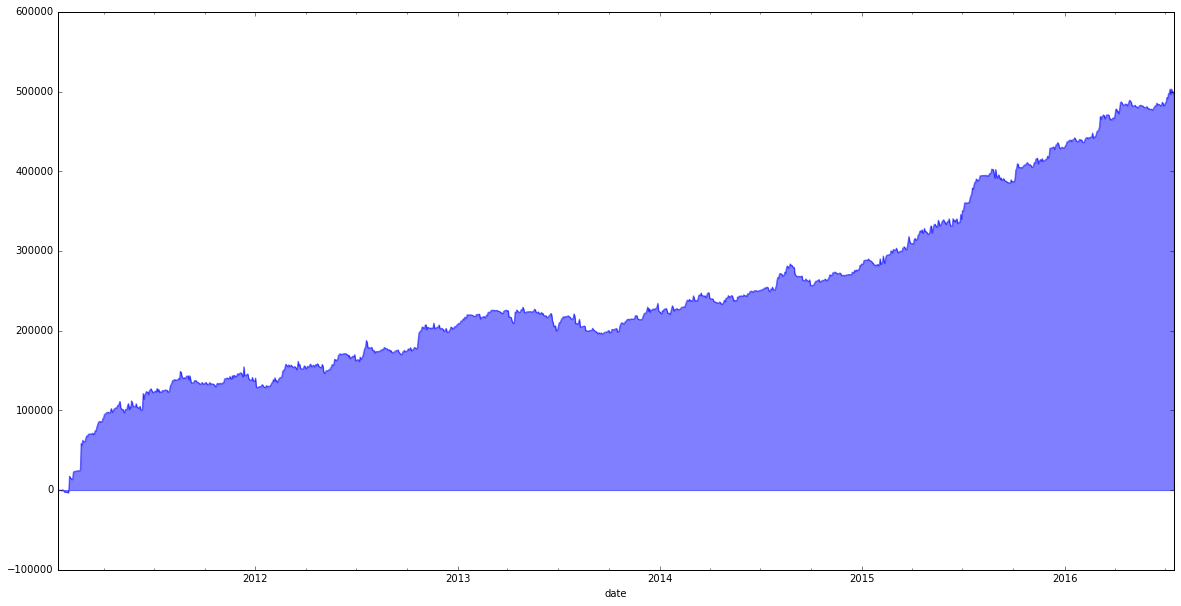

In [52]:
portfolio_stats(all_equities_sum, 'All equities')

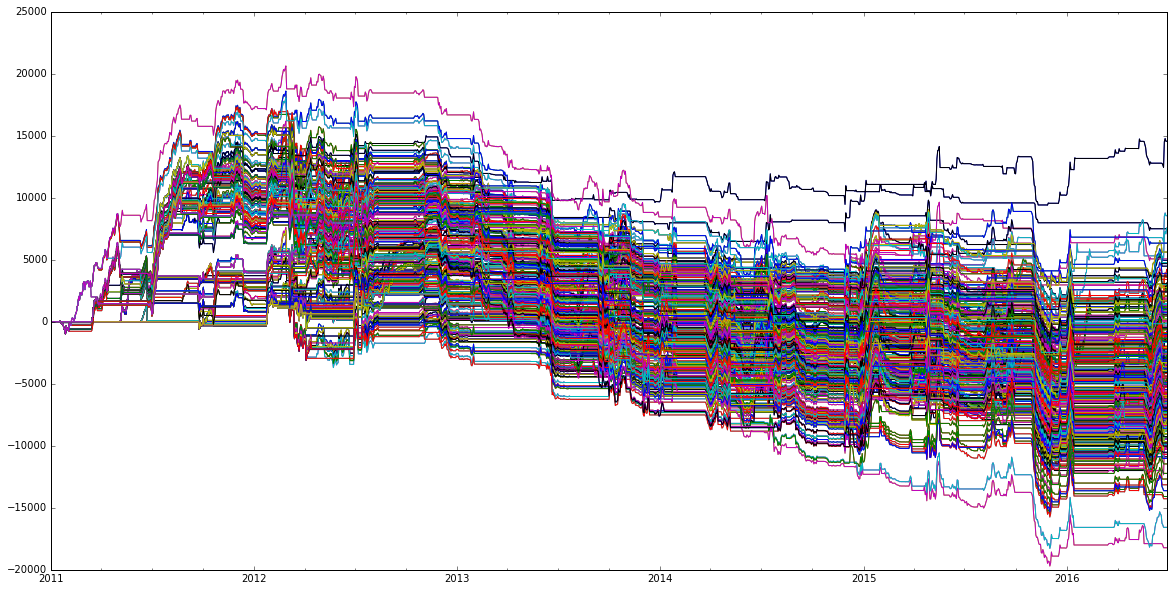

In [250]:
swarm.swarm.plot(legend=False)